<a href="https://colab.research.google.com/github/marcellinusc/plate-recognition/blob/branch-2/character-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

In [3]:
# Match contours to license plate or character template
def _check_contours(boundaries, img_orig, img_preproc, license_plate_check, retr) :

    # Find all contours in the image
    (cntrs, _) = cv2.findContours(img_preproc.copy(), retr, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential boundaries
    lower_width = boundaries[0]
    upper_width = boundaries[1]
    lower_height = boundaries[2]
    upper_height = boundaries[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    if license_plate_check is True :
        cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:5]
    else :
        cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :

        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # Check if contour has proper sizes
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :

            x_cntr_list.append(intX)
            target_contours.append(cntr)

            # If we check a license plate, crop the license plate
            if license_plate_check is True :
                img_res = img_orig[intY:intY+intHeight, intX:intX+intWidth, :]

            # If we check a character, crop the character
            if license_plate_check is False :

                char = img_orig[intY:intY+intHeight, intX:intX+intWidth]
                w, h = round(char.shape[1]/char.shape[0] * 40), 40
                char = cv2.resize(char, (w, h))

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)
                img_res.append(char)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    if license_plate_check is False:
        indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
        img_res_copy = []
        target_contours_copy = []
        for idx in indices:
            img_res_copy.append(img_res[idx])
            target_contours_copy.append(target_contours[idx])
        img_res = img_res_copy
        target_contours = target_contours_copy

    return target_contours, img_res

In [4]:
# Crop license plates
def segment_license_plate(image) :

    IMAGE_HEIGHT = 100
    IMAGE_WIDTH = 200

    # Preprocess image
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Define expected boundaries of detected license plate
    lower_width_lp = IMAGE_WIDTH/4
    upper_width_lp = 8*IMAGE_WIDTH/10
    lower_height_lp= IMAGE_HEIGHT/4
    upper_height_lp = 2*IMAGE_HEIGHT/3

    boundaries_lp = [lower_width_lp,
                  upper_width_lp,
                  lower_height_lp,
                  upper_height_lp]


    # Retrieve the probable cropped license plate
    plate_contours, img_lp = _check_contours(boundaries_lp, image, img_binary, True)

    if len(plate_contours) == 0 :
        invert_img = np.invert(img_binary)

        # Check contour of inverted image if it's possibly a license plate
        plate_contours, img_lp = _check_contours(boundaries_lp, image, invert_img, True)


    # If no license plate was found, return the biggest contour
    if len(plate_contours) == 0 :

         (contours, _) = cv2.findContours(img_binary.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
         contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

         plate_contours = []
         for contour in contours :
             intX, intY, intWidth, intHeight = cv2.boundingRect(contour)
             img_lp = image[intY:intY+intHeight,intX:intX+intWidth,:]
             plate_contours.append(contour)

    return img_lp

In [5]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    LP_WIDTH = 75
    LP_HEIGHT = 150
    img_lp = cv2.resize(image, (LP_HEIGHT, LP_WIDTH))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Estimations of character contours sizes of cropped license plates
    boundaries_crop = [LP_WIDTH/30,
                       LP_WIDTH/3,
                       LP_HEIGHT/8,
                       2*LP_HEIGHT/3]

    # Estimations of character contour sizes of non-cropped license plates
    boundaries_no_crop = [LP_WIDTH/12,
                          LP_WIDTH/6,
                          LP_HEIGHT/8,
                          LP_HEIGHT/3]

    # Get contours within cropped license plate
    char_contours, char_list = _check_contours(boundaries_crop, img_binary_lp, img_binary_lp, False,cv2.RETR_EXTERNAL)
    
    if len(char_contours) < 5:

        char_contours, char_list = _check_contours(boundaries_crop, img_binary_lp, img_binary_lp, False,cv2.RETR_TREE)

    if len(char_contours) < 5:

        # Check the smaller contours; possibly no plate was detected at all
        char_contours, char_list = _check_contours(boundaries_no_crop, img_binary_lp, img_binary_lp, False,cv2.RETR_TREE)


    if len(char_contours) == 0 :

            # If nothing was found, try inverting the image in case the background is darker than the foreground
            invert_img_lp = np.invert(img_binary_lp)
            char_contours, char_list = _check_contours(boundaries_crop, img_binary_lp, invert_img_lp, False,cv2.RETR_TREE)

    # If we found 7 chars, it is likely to form a license plate
    full_license_plate = []
    if len(char_contours) >= 5 :

        full_license_plate = char_list
    

    return full_license_plate

In [6]:
from tensorflow.keras.models import load_model

def read_license_plate(path) :
    img = cv2.imread(path)
    # Segmenting
    chars = segment_characters(img)
    # Make sure that the image is white letter with black backgrounnd
    if np.average(np.hstack(chars))/255>0.5:
        chars = [255-s for s in chars]  
    
    for i in range(len(chars)):
        width, height = round(chars[i].shape[1]/chars[i].shape[0] * 28), 28

        widthleft = int(np.floor((28-width)/2))
        widthright = int(np.ceil((28-width)/2))

        canvasleft = np.zeros((28,widthleft))
        canvasright = np.zeros((28,widthright)) 
        
        chars[i] = cv2.resize(chars[i], (width, height))
        chars[i] = np.hstack((canvasleft,chars[i],canvasright))
            
    return chars

def license_number(chars) :
    model = load_model('/content/plate-recognition/saved-model')
    
    lic = ''
    for i in range(len(chars)):
        chars[i] = chars[i].reshape(28,28,1).reshape(-1,28,28,1)
        result = np.argmax(model.predict(chars[i]))
        if result>=10:
            result = chr(result+55) #convert to ASCII
        lic = lic + str(result)

    return lic

BP7309GD


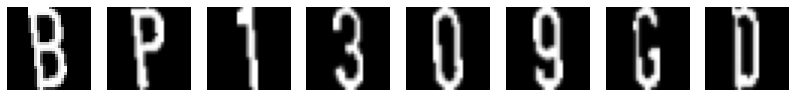

In [15]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

impath='/content/plate-recognition/dataset/test-samples/ID_6.jpg'
characters = read_license_plate(impath)
license = license_number(characters)
print(license)

fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(characters),nrows=1,figure=fig)
for i in range(len(characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(characters[i][0,:,:,0],cmap="gray")